In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Library

In [2]:
!pip install ultralytics
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# Set up paths of files

In [3]:
import os
project_folder = "/content/drive/MyDrive/Colab Notebooks/Bottle/"

real_zip = project_folder + "real_augmented.yolov8.zip"
synthetic_zip = project_folder + "synthetic_augmented.yolov8.zip"

real_folder = "/content/realdata"
synthetic_folder = "/content/syntheticdata"

export_path = os.path.join(project_folder, "Models")
os.makedirs(export_path, exist_ok=True)


In [4]:
# Unzip datasets
import zipfile

os.makedirs(real_folder, exist_ok=True)
os.makedirs(synthetic_folder, exist_ok=True)

with zipfile.ZipFile(real_zip, 'r') as zip_ref:
    zip_ref.extractall(real_folder)

with zipfile.ZipFile(synthetic_zip, 'r') as zip_ref:
    zip_ref.extractall(synthetic_folder)

# Dataset Summary




In [5]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data_folders = [real_folder, synthetic_folder]
sub_folders = ['train', 'valid', 'test']


In [6]:
for folder in data_folders:
    print(f"Summary for dataset: {folder}")
    for sub in sub_folders:
        img_dir = os.path.join(folder, sub, 'images')
        lbl_dir = os.path.join(folder, sub, 'labels')
        if os.path.exists(img_dir) and os.path.exists(lbl_dir):
            img_count = len(os.listdir(img_dir))
            lbl_count = len(os.listdir(lbl_dir))
            print(f"  {sub} - Images: {img_count}, Labels: {lbl_count}")
        else:
            print(f"  {sub} - MISSING either images or labels folder.")
    print('-' * 40)

Summary for dataset: /content/realdata
  train - Images: 420, Labels: 420
  valid - Images: 120, Labels: 120
  test - Images: 60, Labels: 60
----------------------------------------
Summary for dataset: /content/syntheticdata
  train - Images: 420, Labels: 420
  valid - Images: 120, Labels: 120
  test - Images: 60, Labels: 60
----------------------------------------


In [7]:
# Function to plot image with YOLO labels
def plot_image_with_labels(img_path, labels_dir):
    try:
        img = Image.open(img_path)
        plt.imshow(img)
        ax = plt.gca()
        img_w, img_h = img.size
        label_file = os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    x_min = (x - w / 2) * img_w
                    y_min = (y - h / 2) * img_h
                    rect = patches.Rectangle((x_min, y_min), w * img_w, h * img_h,
                                             linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error with {img_path}: {e}")

Sample annotated images from: /content/realdata


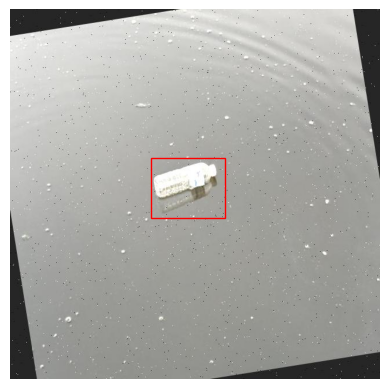

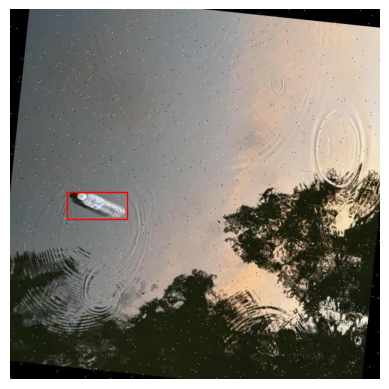

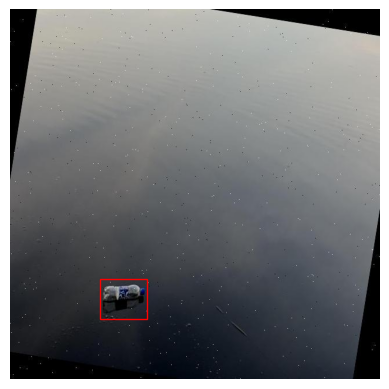

Sample annotated images from: /content/syntheticdata


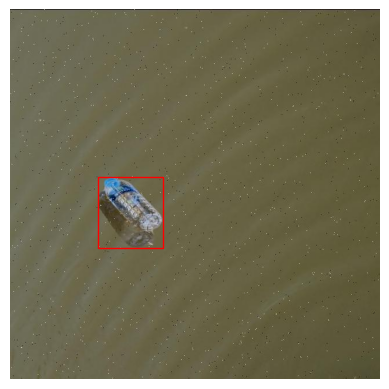

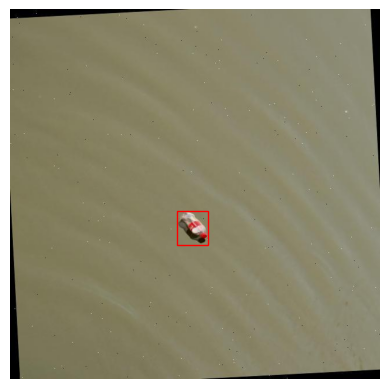

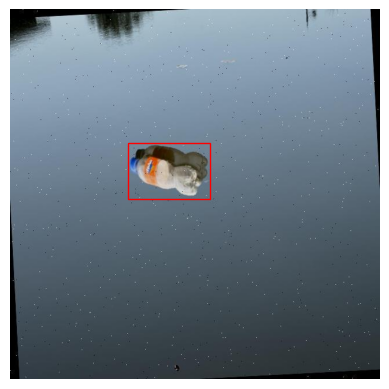

In [8]:
# Display a few annotated examples
for folder in data_folders:
    print(f"Sample annotated images from: {folder}")
    for sub in sub_folders:
        img_dir = os.path.join(folder, sub, 'images')
        lbl_dir = os.path.join(folder, sub, 'labels')
        if not os.path.exists(img_dir): continue
        images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
        if images:
            img_path = os.path.join(img_dir, random.choice(images))
            plot_image_with_labels(img_path, lbl_dir)

# Object Detection Model (YOLO)

## Function & Hyperparameter

In [9]:
# Function to visualize model predictions vs ground truth
def visualize_comparisons_test(folder, model):
    test_img_dir = os.path.join(folder, 'test/images')
    test_lbl_dir = os.path.join(folder, 'test/labels')
    images = sorted(os.listdir(test_img_dir))
    for img_file in images:
        img_path = os.path.join(test_img_dir, img_file)
        label_path = os.path.join(test_lbl_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        try:
            img = Image.open(img_path)
            results = model.predict(source=img_path, conf=0.25)
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(img)
            img_w, img_h = img.size
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        cls, x, y, w, h = map(float, line.strip().split())
                        x_min = (x - w / 2) * img_w
                        y_min = (y - h / 2) * img_h
                        rect = patches.Rectangle((x_min, y_min), w * img_w, h * img_h,
                                                 linewidth=2, edgecolor='r', facecolor='none')
                        axs[0].add_patch(rect)
            axs[0].set_title("Ground Truth")
            axs[0].axis('off')

            im_array = results[0].plot()
            axs[1].imshow(im_array[:, :, ::-1])
            axs[1].set_title("Prediction")
            axs[1].axis('off')

            fig.suptitle(f"{folder}/test - {img_file}", fontsize=14)
            plt.tight_layout()
            plt.show()
            break  # Just one example
        except Exception as e:
            print(f"Error processing {img_file}: {e}")

In [10]:
import yaml
import shutil
import pandas as pd
from ultralytics import YOLO

# Load YOLOv8 model (version: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x)
versions = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x']

# Hyperparameter
epochs = 32
batch = 16


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Train on Real dataset, Test on Real dataset

In [ ]:
# Create an empty list to store the validation results
validation_results = []

for version in versions:
  real_data_yaml = {
    'train': os.path.join(real_folder, 'train/images'),
    'val': os.path.join(real_folder, 'valid/images'),
    'nc': 1,
    'names': ['bottle']
  }
  with open(os.path.join(real_folder, 'data.yaml'), 'w') as f:
    yaml.dump(real_data_yaml, f)

  model_real = YOLO(f'{version}.pt')
  model_real.train(data=os.path.join(real_folder, 'data.yaml'), epochs=epochs, imgsz=640, batch=batch,
                      project='runs', name='real_train')

  # Validation with mAP50, mAP50-95
  metrics_real = model_real.val(data=os.path.join(real_folder, 'data.yaml'))

  # Extract evaluation metrics
  map50 = metrics_real.box.map50        # mAP@0.5
  map50_95 = metrics_real.box.map       # mAP@0.5:0.95
  precision = metrics_real.box.p[0]
  recall = metrics_real.box.r[0]

  # Append the results to the list
  validation_results.append({
    'Version': version,
    'mAP50': map50,
    'mAP50-95': map50_95,
    'Precision': precision,
    'Recall': recall
  })

  # Export and copy real model
  real_onnx = model_real.export(format="onnx", imgsz=640, half=True, dynamic=True, simplify=True,
                                        opset=12, workspace=4, verbose=True)
  shutil.copy2(real_onnx, os.path.join(export_path, f"best_real_{version}.onnx"))

validation_results.append({
    'epochs' : f"{epochs}",
    'batch'  : f"{batch}",
})

100%|██████████| 6.25M/6.25M [00:00<00:00, 116MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/realdata/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=real_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

100%|██████████| 755k/755k [00:00<00:00, 23.3MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 107MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1226.1±597.5 MB/s, size: 33.0 KB)


train: Scanning /content/realdata/train/labels... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<00:00, 2150.29it/s]


train: New cache created: /content/realdata/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 680.7±328.4 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 2167.73it/s]

val: New cache created: /content/realdata/valid/labels.cache


Plotting labels to runs/real_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/real_train
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      2.12G      1.281       2.69      1.185          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        120        120    0.00322      0.967      0.156     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32       2.6G      1.279      1.853      1.263          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        120        120    0.00192      0.575    0.00242    0.00112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      2.62G      1.362      1.741      1.276          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        120        120       0.84      0.483      0.642      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      2.64G      1.279      1.504      1.214         10        640: 100%|██████████| 27/27 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


                   all        120        120      0.658      0.658      0.695      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      2.65G      1.342      1.407      1.252         10        640: 100%|██████████| 27/27 [00:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        120        120      0.691      0.746      0.713      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      2.67G      1.311      1.263      1.237          8        640: 100%|██████████| 27/27 [00:06<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        120        120      0.836       0.85      0.856      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      2.68G      1.286      1.155      1.247          6        640: 100%|██████████| 27/27 [00:06<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        120        120      0.964        0.9      0.964      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      2.71G      1.273      1.046      1.205          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        120        120      0.942      0.933      0.978      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      2.72G      1.199     0.9604      1.201          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        120        120      0.952      0.925      0.962      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      2.74G      1.202     0.9056      1.216          9        640: 100%|██████████| 27/27 [00:07<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


                   all        120        120      0.838      0.817      0.834      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      2.75G      1.213     0.8993      1.205          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        120        120      0.953      0.933      0.977       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      2.77G      1.204     0.8904      1.217          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


                   all        120        120      0.984      0.925      0.986      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      2.79G      1.179     0.8028      1.194          7        640: 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        120        120      0.957       0.95      0.981      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32       2.8G       1.15     0.8044      1.163          3        640: 100%|██████████| 27/27 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        120        120      0.915      0.933       0.97       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      2.81G      1.154      0.795      1.202          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        120        120      0.948      0.925      0.966      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      2.84G      1.136     0.7676      1.175          6        640: 100%|██████████| 27/27 [00:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        120        120      0.894      0.992      0.984      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      2.86G      1.093     0.7323      1.138          9        640: 100%|██████████| 27/27 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        120        120      0.983      0.925      0.989      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      2.87G      1.003     0.6699      1.106          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


                   all        120        120      0.964      0.975       0.99      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      2.88G      1.042     0.6669      1.146          8        640: 100%|██████████| 27/27 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        120        120      0.992      0.997      0.994      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      2.91G      1.043     0.6453      1.141          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        120        120      0.979      0.983      0.994        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      2.92G      1.021      0.636      1.119          7        640: 100%|██████████| 27/27 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        120        120      0.963      0.975      0.991      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      2.94G     0.9985     0.6036      1.103          3        640: 100%|██████████| 27/27 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        120        120      0.961      0.975      0.993      0.701


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      2.95G     0.9105     0.5868      1.083          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        120        120      0.983      0.985      0.992      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      2.97G     0.9098     0.5472       1.07          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        120        120      0.972      0.975      0.993       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      2.99G     0.8822     0.5503      1.047          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        120        120       0.99      0.992      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      3.01G     0.8372     0.5162      1.026          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        120        120      0.975      0.992      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      3.02G     0.8053     0.4901      1.027          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        120        120      0.982      0.992      0.994      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      3.04G     0.7764     0.4559      1.018          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        120        120      0.986      0.983      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      3.06G     0.7874     0.4668       1.02          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        120        120          1      0.991      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      3.08G      0.776     0.4534      1.012          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        120        120      0.992      0.998      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      3.08G     0.7639     0.4496      1.013          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        120        120          1      0.998      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      3.11G     0.7314     0.4386     0.9832          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        120        120      0.998          1      0.995      0.755



32 epochs completed in 0.076 hours.
Optimizer stripped from runs/real_train/weights/last.pt, 6.2MB
Optimizer stripped from runs/real_train/weights/best.pt, 6.2MB

Validating runs/real_train/weights/best.pt...
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


                   all        120        120      0.992      0.998      0.995      0.759
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/real_train
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 939.5±489.0 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


                   all        120        120      0.992      0.998      0.995       0.76
Speed: 3.5ms preprocess, 6.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/real_train2
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/real_train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.46', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 258.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 287.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 254.9 MB

100%|██████████| 21.5M/21.5M [00:00<00:00, 200MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/realdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=real_train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /content/realdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 427.6±396.4 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/real_train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/real_train3
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32       4.1G      1.335      2.923      1.275          6        640: 100%|██████████| 27/27 [00:10<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        120        120       0.91      0.858      0.928      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      4.86G      1.335      1.191      1.309          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        120        120      0.771      0.619      0.711      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      4.86G      1.407     0.9978      1.323          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        120        120     0.0107     0.0667    0.00326    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      4.86G      1.365     0.9639      1.292         10        640: 100%|██████████| 27/27 [00:07<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        120        120      0.347     0.0917     0.0722     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      4.86G       1.39      1.013      1.298         10        640: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        120        120      0.511      0.383      0.376      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      4.86G      1.338     0.8932      1.273          8        640: 100%|██████████| 27/27 [00:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        120        120    0.00309      0.417    0.00247    0.00123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      4.86G      1.337     0.8653      1.281          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        120        120      0.135        0.4      0.108     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      4.86G      1.371     0.8467      1.299          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        120        120       0.83      0.816      0.888      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      4.86G      1.248     0.7689      1.244          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        120        120      0.802      0.717      0.828      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      4.86G      1.281     0.7724      1.293          9        640: 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        120        120      0.896      0.842      0.917      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      4.86G      1.294     0.7583      1.243          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        120        120      0.929        0.9      0.956      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      4.86G      1.221     0.7688      1.201          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        120        120      0.872      0.908      0.961      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      4.86G      1.181     0.6996      1.207          7        640: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        120        120       0.93      0.933      0.977      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      4.86G      1.139     0.6656      1.187          3        640: 100%|██████████| 27/27 [00:07<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        120        120      0.913      0.942      0.978      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      4.86G      1.223     0.7161       1.25          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        120        120      0.919      0.943      0.981      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      4.86G      1.169     0.6754      1.203          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        120        120      0.903       0.95       0.97      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      4.86G      1.117     0.6498      1.157          9        640: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        120        120      0.975      0.961      0.985      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      4.86G      1.059        0.6      1.152          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        120        120      0.983      0.946      0.988      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      4.86G      1.104     0.6402      1.196          8        640: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        120        120      0.991      0.948      0.991      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      4.86G      1.058      0.614      1.153          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        120        120      0.952      0.995      0.992      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      4.86G      1.041     0.5997      1.145          7        640: 100%|██████████| 27/27 [00:07<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        120        120      0.973      0.958      0.986      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      4.86G      1.038     0.5739       1.13          3        640: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        120        120      0.973      0.975      0.994      0.712


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      4.86G     0.9187     0.4966      1.131          4        640: 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        120        120      0.975      0.979      0.993       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      4.86G      0.927     0.4851      1.139          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        120        120      0.972      0.983      0.993      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      4.86G     0.9149     0.4762      1.102          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        120        120      0.967      0.984      0.993      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      4.86G     0.8628     0.4485      1.083          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        120        120      0.992      0.975      0.994      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      4.86G     0.8471      0.434      1.079          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        120        120      0.973          1      0.994      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      4.88G     0.8211      0.418      1.062          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        120        120      0.983      0.992      0.994      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      4.89G     0.8147      0.415      1.062          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        120        120      0.983      0.989      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      4.89G     0.7993     0.3985      1.048          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        120        120      0.975      0.992      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      4.89G     0.7674     0.3847      1.051          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        120        120      0.976      0.992      0.994      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      4.89G     0.7436     0.3803      1.024          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        120        120      0.992      0.992      0.995      0.757



32 epochs completed in 0.089 hours.
Optimizer stripped from runs/real_train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/real_train3/weights/best.pt, 22.5MB

Validating runs/real_train3/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


                   all        120        120      0.992      0.992      0.995      0.755
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/real_train3
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1243.6±646.3 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


                   all        120        120      0.992      0.992      0.995      0.754
Speed: 2.0ms preprocess, 10.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/real_train32
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/real_train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 5.4s, saved as 'runs/real_train3/weights/best.onnx' (42.5 MB)

Export complete (6.2s)
Results saved to /content/runs/real_train3/weights
Predict:         yolo predict task=detect model=runs/real_train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/real_train3/weights/best.onnx imgsz=640 data=/content/realdata/data.yaml  
Visualize:       https://netro

100%|██████████| 49.7M/49.7M [00:00<00:00, 343MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/realdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=real_train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /content/realdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 366.2±277.0 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/real_train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/real_train4
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32       6.2G      1.342      2.199      1.351          6        640: 100%|██████████| 27/27 [00:15<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        120        120     0.0323      0.592     0.0302     0.0156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      7.34G      1.477      1.244       1.41          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        120        120   0.000632      0.183    0.00037   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      7.41G      1.552       1.27      1.448          6        640: 100%|██████████| 27/27 [00:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        120        120   4.79e-05    0.00833   2.42e-05   4.84e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      6.35G      1.568      1.215      1.452         10        640: 100%|██████████| 27/27 [00:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        120        120    0.00708      0.125    0.00239   0.000779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32       6.3G      1.594       1.37      1.481         10        640: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        120        120     0.0568       0.45      0.032     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      6.38G      1.518      1.236      1.423          8        640: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        120        120       0.31      0.427      0.209      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      6.37G      1.476       1.07      1.377          6        640: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        120      0.767      0.576      0.622      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      6.39G      1.429      1.034      1.357          6        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        120        120      0.778      0.584      0.617      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      6.34G      1.415      1.001      1.361          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        120        120      0.897      0.733      0.836      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      6.37G      1.495      0.953      1.413          9        640: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        120       0.93        0.8      0.888      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      6.36G      1.383      0.926      1.313          6        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        120        120      0.877      0.742       0.84      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      6.38G      1.317     0.9115      1.301          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        120        120      0.824      0.842      0.863       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      6.29G      1.269     0.8152      1.273          7        640: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        120        120      0.878      0.837      0.887      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      6.37G      1.292      0.847       1.28          3        640: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        120        120      0.855      0.638      0.763      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      6.37G       1.32     0.8392      1.305          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        120        120      0.962      0.942      0.983       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      6.39G      1.278     0.7836      1.287          6        640: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        120        120      0.918      0.935      0.966      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      6.34G      1.204     0.7603       1.23          9        640: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        120        120      0.943      0.965      0.983      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      6.38G      1.155     0.7115      1.207          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        120      0.923      0.933      0.977      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      6.37G      1.185     0.7231      1.261          8        640: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        120        120      0.965       0.93      0.973      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      6.39G       1.16     0.7234      1.229          6        640: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        120        120      0.943      0.917      0.975      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      6.34G      1.152     0.6866      1.213          7        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        120        120      0.936      0.958      0.974      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      6.38G      1.113     0.6416       1.18          3        640: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        120        120      0.977      0.942      0.991      0.679


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      6.37G      1.059      0.579      1.218          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        120        120      0.966      0.975      0.988      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32       6.4G      1.024     0.5596      1.213          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        120        120       0.95      0.941      0.988      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      6.33G       1.03     0.5499      1.177          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        120        120      0.952       0.95      0.986      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      6.38G     0.9787     0.5201      1.148          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        120        120      0.966      0.961      0.989      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      6.37G     0.9515     0.5229      1.144          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        120        120      0.971      0.975      0.988      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      6.38G      0.916     0.4918      1.118          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        120        120      0.975      0.975      0.989      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      6.33G     0.8862     0.4681      1.116          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        120        120      0.992      0.975      0.992       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      6.38G       0.91     0.4737      1.118          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        120        120      0.943      0.973      0.989      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      6.37G     0.8776     0.4539      1.117          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        120        120      0.974      0.983      0.994      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      6.39G     0.8489     0.4453      1.085          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        120        120      0.983      0.988      0.994      0.728



32 epochs completed in 0.205 hours.
Optimizer stripped from runs/real_train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/real_train4/weights/best.pt, 52.0MB

Validating runs/real_train4/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


                   all        120        120      0.983      0.988      0.994      0.729
Speed: 0.3ms preprocess, 10.6ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/real_train4
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1612.3±637.6 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


                   all        120        120      0.983      0.988      0.994      0.728
Speed: 3.3ms preprocess, 22.6ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/real_train42
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/real_train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 6.9s, saved as 'runs/real_train4/weights/best.onnx' (98.7 MB)

Export complete (8.6s)
Results saved to /content/runs/real_train4/weights
Predict:         yolo predict task=detect model=runs/real_train4/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/real_train4/weights/best.onnx imgsz=640 data=/content/realdata/data.yaml  
Visualize:       https://netro

100%|██████████| 83.7M/83.7M [00:00<00:00, 150MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/realdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=real_train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /content/realdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 404.6±186.7 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/real_train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/real_train5
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      9.26G       1.43      5.005       1.56          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        120        120    0.00133      0.333   0.000898   0.000414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      9.58G      1.603          2      1.797          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        120        120    0.00163     0.0833   0.000723   0.000229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      9.58G      1.677      1.613      1.907          6        640: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        120        120   0.000606      0.025   0.000257   8.26e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      9.68G      1.759       1.64      2.004         10        640: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        120        120    0.00516       0.25    0.00282    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      9.58G      1.691      1.347      1.915         10        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        120        120     0.0233        0.4     0.0136    0.00456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      9.83G      1.592      1.313      1.841          8        640: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        120        120      0.501      0.375      0.357      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      9.81G       1.53      1.194      1.766          6        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        120        120      0.826      0.475      0.605      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      9.84G      1.505      1.072      1.724          6        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        120        120      0.738      0.633      0.656      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      9.58G      1.453      1.019      1.698          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        120        120      0.623      0.408      0.472       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      9.83G      1.479       1.06      1.733          9        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        120        120      0.832      0.743       0.84      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      9.79G      1.412      1.004      1.632          6        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        120        120      0.795      0.717      0.817      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      9.75G      1.344      0.976      1.582          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        120        120      0.749      0.621       0.65      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      9.88G      1.324     0.8891      1.608          7        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        120        120      0.816       0.74      0.837      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      9.82G      1.329     0.9269      1.594          3        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        120        120      0.835      0.758      0.885       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32       9.7G       1.37     0.9197      1.607          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        120        120      0.897      0.799      0.884      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      9.76G      1.321     0.8667      1.565          6        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        120        120      0.817      0.858      0.885      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      9.58G      1.261     0.8236      1.519          9        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        120        120      0.908      0.867       0.91      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      9.73G      1.199     0.7977      1.491          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        120        120      0.769       0.75      0.808      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32       9.7G      1.275      0.841      1.567          8        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        120        120      0.778      0.633      0.687      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      9.85G      1.227     0.7841      1.493          6        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        120        120      0.901      0.825      0.912      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      9.68G      1.175     0.7543      1.475          7        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        120        120       0.86      0.925      0.958      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      9.83G      1.136     0.7088      1.419          3        640: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        120        120      0.948       0.92      0.984       0.64


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32       9.7G      1.092     0.6733      1.463          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        120        120      0.931        0.9       0.97      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      9.83G      1.064     0.6175      1.432          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        120        120      0.927      0.942      0.983      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      9.58G      1.057      0.643      1.429          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        120        120      0.925      0.929      0.979      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      9.73G      1.002     0.6075      1.364          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        120        120      0.942      0.946      0.985      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32       9.8G       1.03     0.5961      1.411          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        120        120      0.942      0.941       0.98      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      9.74G     0.9712     0.5609      1.353          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        120        120      0.991      0.968      0.994      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      9.58G     0.9594     0.5383      1.354          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        120        120      0.983      0.956       0.99      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      9.72G     0.9517     0.5303      1.354          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        120        120      0.949      0.975      0.991      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32       9.8G     0.9332      0.509       1.33          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        120        120      0.975      0.965      0.992      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      9.75G     0.9361     0.5086      1.316          4        640: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.972      0.975      0.992      0.704



32 epochs completed in 0.363 hours.
Optimizer stripped from runs/real_train5/weights/last.pt, 87.6MB
Optimizer stripped from runs/real_train5/weights/best.pt, 87.6MB

Validating runs/real_train5/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all        120        120      0.972      0.975      0.992      0.704
Speed: 0.3ms preprocess, 17.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/real_train5
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1531.6±633.6 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


                   all        120        120      0.975      0.975      0.992      0.704
Speed: 2.3ms preprocess, 38.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/real_train52
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/real_train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (83.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 23.7s, saved as 'runs/real_train5/weights/best.onnx' (166.5 MB)

Export complete (27.0s)
Results saved to /content/runs/real_train5/weights
Predict:         yolo predict task=detect model=runs/real_train5/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/real_train5/weights/best.onnx imgsz=640 data=/content/realdata/data.yaml  
Visualize:       https://ne

100%|██████████| 131M/131M [00:05<00:00, 25.4MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/realdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=real_train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /content/realdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 468.1±82.6 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/real_train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/real_train6
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      11.3G       1.55      5.623      1.619          6        640: 100%|██████████| 27/27 [00:34<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120   8.73e-05      0.025   4.48e-05   7.51e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      12.1G      1.663      2.943      1.934          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        120        120          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      12.1G      1.807      1.936      2.069          6        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        120        120          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      12.2G      1.782      1.724      2.024         10        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        120        120   0.000253     0.0167   8.82e-05    4.4e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      12.2G      1.792      1.719      2.054         10        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120    2.8e-05    0.00833   1.42e-05   1.42e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      12.3G      1.748      1.497      2.026          8        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        120        120      0.482      0.192      0.227     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      12.3G      1.616      1.322      1.912          6        640: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        120        120      0.535       0.55      0.484      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      12.3G      1.563      1.285       1.89          6        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120      0.679      0.575      0.581      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      12.1G      1.536       1.21      1.899          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.794      0.767      0.825      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      12.3G      1.645      1.198      1.971          9        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120      0.754      0.567      0.631       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      12.3G      1.527       1.11      1.811          6        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        120        120        0.7      0.584      0.628      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      12.3G       1.43      1.092      1.743          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120      0.678      0.617      0.623      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      12.1G        1.4     0.9575      1.759          7        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.705      0.539      0.578      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      12.3G      1.398     0.9343      1.698          3        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        120        120      0.797      0.683      0.743      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      12.3G      1.413     0.9496      1.756          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.832      0.373      0.408      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      12.3G      1.368     0.9013      1.717          6        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        120        120      0.881      0.825        0.9      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      12.2G      1.309     0.8874      1.625          9        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        120        120      0.846      0.783      0.875      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      12.3G       1.23     0.8358       1.63          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.898      0.805      0.913      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      12.3G      1.294     0.8202      1.687          8        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120       0.86      0.808      0.909      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      12.3G      1.287      0.845      1.658          6        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        120        120      0.854      0.876      0.936      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      12.2G      1.242      0.809       1.63          7        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.814      0.858      0.889      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      12.3G      1.198     0.7561      1.551          3        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        120        120      0.869      0.885      0.921      0.587


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      12.3G      1.215     0.7827      1.737          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.891      0.858      0.953      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      12.3G      1.211     0.7485      1.754          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        120        120       0.88      0.875      0.922      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      12.1G      1.159     0.7328      1.683          4        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        120        120      0.835      0.858      0.922      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      12.3G      1.111     0.6881      1.641          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        120        120      0.904      0.875      0.951      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      11.9G      1.107     0.6811       1.65          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.849      0.891      0.931      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      12.3G      1.091     0.6348      1.619          4        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120      0.829      0.891       0.94      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      12.1G       1.04     0.6236      1.583          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.839      0.954      0.963      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      12.3G       1.09     0.6419      1.656          4        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        120        120      0.859      0.958      0.959      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      12.3G      1.018     0.5891      1.562          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        120        120      0.916      0.925      0.974      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      12.3G      1.033     0.5984      1.586          4        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        120        120       0.93      0.925      0.973      0.662



32 epochs completed in 0.590 hours.
Optimizer stripped from runs/real_train6/weights/last.pt, 136.7MB
Optimizer stripped from runs/real_train6/weights/best.pt, 136.7MB

Validating runs/real_train6/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


                   all        120        120       0.93      0.925      0.973      0.663
Speed: 0.2ms preprocess, 27.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/real_train6
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1220.7±734.6 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


                   all        120        120      0.939      0.925      0.971      0.662
Speed: 2.7ms preprocess, 67.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/real_train62
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/real_train6/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (130.4 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 66.2s, saved as 'runs/real_train6/weights/best.onnx' (260.0 MB)

Export complete (72.4s)
Results saved to /content/runs/real_train6/weights
Predict:         yolo predict task=detect model=runs/real_train6/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/real_train6/weights/best.onnx imgsz=640 data=/content/realdata/data.yaml  
Visualize:       https://n

In [ ]:
# Create a Pandas DataFrame from the results
df_validation = pd.DataFrame(validation_results)
df_validation

# save the DataFrame to a CSV file
df_validation.to_csv(os.path.join(export_path, 'real_validation_results.csv'), index=False)


In [ ]:
for version in versions:
    model_path = os.path.join(export_path, f"best_real_{version}.onnx")
    model = YOLO(model_path)
    visualize_comparisons_test(real_folder, model)


Output hidden; open in https://colab.research.google.com to view.

## Train on Synthetic dataste, Test on Real dataset

In [11]:
# Create an empty list to store the validation results
validation_results = []

for version in versions:
  synthetic_data_yaml = {
    'train': os.path.join(synthetic_folder, 'train/images'),
    'val': os.path.join(real_folder, 'valid/images'),
    'nc': 1,
    'names': ['bottle']
  }
  with open(os.path.join(synthetic_folder, 'data.yaml'), 'w') as f:
    yaml.dump(synthetic_data_yaml, f)

  model_synthetic = YOLO(f'{version}.pt')
  model_synthetic.train(data=os.path.join(synthetic_folder, 'data.yaml'), epochs=epochs, imgsz=640, batch=batch,
                      project='runs', name='synthetic_train')

  # Validation with mAP50, mAP50-95
  metrics_synthetic = model_synthetic.val(data=os.path.join(real_folder, 'data.yaml'))

  # Extract evaluation metrics
  map50 = metrics_synthetic.box.map50        # mAP@0.5
  map50_95 = metrics_synthetic.box.map       # mAP@0.5:0.95
  precision = metrics_synthetic.box.p[0]
  recall = metrics_synthetic.box.r[0]

  # Append the results to the list
  validation_results.append({
    'Version': version,
    'mAP50': map50,
    'mAP50-95': map50_95,
    'Precision': precision,
    'Recall': recall
  })

  # Export and copy synthetic model
  synthetic_onnx = model_synthetic.export(format="onnx", imgsz=640, half=True, dynamic=True, simplify=True,
                                        opset=12, workspace=4, verbose=True)
  synthetic_model_path = synthetic_onnx
  shutil.copy2(synthetic_model_path, os.path.join(export_path, f"best_synthetic_{version}.onnx"))

validation_results.append({
    'epochs' : f"{epochs}",
    'batch'  : f"{batch}",
})

100%|██████████| 6.25M/6.25M [00:00<00:00, 360MB/s]

Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/syntheticdata/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synthetic_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=runs, rect=False, resume=False, retina_

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 125MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1132.1±408.5 MB/s, size: 39.4 KB)


train: Scanning /content/syntheticdata/train/labels... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<00:00, 2450.88it/s]

train: New cache created: /content/syntheticdata/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 626.8±308.1 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 1472.34it/s]

val: New cache created: /content/realdata/valid/labels.cache


Plotting labels to runs/synthetic_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/synthetic_train
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      2.13G      1.123      2.516       1.09          7        640: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        120        120      0.854      0.734      0.811      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      2.61G      1.193      1.704      1.124          6        640: 100%|██████████| 27/27 [00:06<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        120        120      0.927      0.107      0.248      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      2.62G      1.184      1.532      1.147          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        120        120      0.838      0.216      0.365      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      2.64G      1.193      1.367      1.122          9        640: 100%|██████████| 27/27 [00:06<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


                   all        120        120      0.662      0.767      0.751      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      2.66G       1.22      1.269      1.136         12        640: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        120        120      0.801      0.739      0.761      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      2.68G      1.143      1.134      1.139          9        640: 100%|██████████| 27/27 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        120        120       0.86      0.733      0.817      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      2.68G      1.134       1.03      1.111          8        640: 100%|██████████| 27/27 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        120        120      0.598       0.55      0.513      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      2.71G      1.121      0.964      1.128          5        640: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


                   all        120        120      0.857      0.775       0.84      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      2.73G      1.139     0.9328      1.158          3        640: 100%|██████████| 27/27 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        120        120      0.829      0.758        0.8      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      2.75G      1.117      0.871      1.138          8        640: 100%|██████████| 27/27 [00:07<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        120        120      0.872      0.855      0.912      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      2.75G      1.067     0.7937      1.114          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


                   all        120        120      0.747      0.775      0.824      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      2.78G      1.063     0.8067      1.122          6        640: 100%|██████████| 27/27 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


                   all        120        120      0.955      0.874      0.958      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32       2.8G      1.079     0.7706      1.125          8        640: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        120        120      0.906      0.925      0.936      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      2.81G     0.9957     0.7161      1.098          3        640: 100%|██████████| 27/27 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all        120        120      0.875      0.858      0.917      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      2.82G      1.084     0.7231      1.158          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        120        120        0.9        0.9      0.951      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      2.85G     0.9883     0.6628      1.063          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        120        120      0.881      0.867      0.895      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      2.87G      1.015     0.6903        1.1          8        640: 100%|██████████| 27/27 [00:06<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        120        120      0.891      0.888      0.943      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      2.88G     0.9506     0.6314      1.082          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        120        120      0.911      0.842       0.92      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      2.89G     0.9108      0.614      1.052          8        640: 100%|██████████| 27/27 [00:06<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        120        120      0.962      0.925      0.955      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      2.92G     0.9144      0.589      1.048          7        640: 100%|██████████| 27/27 [00:06<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        120        120      0.955      0.885      0.972      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      2.93G     0.9076     0.5718       1.03          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        120        120      0.897       0.95      0.948      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      2.95G     0.8671     0.5535       1.03          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        120        120      0.926      0.925      0.956      0.691


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      2.96G      0.764     0.5096      1.007          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        120        120      0.948      0.958      0.963      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      2.98G      0.782     0.4828      0.994          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        120        120        0.9      0.901      0.947      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32         3G     0.7442     0.4873     0.9837          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        120        120      0.949      0.937      0.965      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      3.02G     0.7219     0.4596     0.9698          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


                   all        120        120       0.95      0.942      0.979      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      3.02G     0.7152     0.4509     0.9614          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        120        120      0.956      0.915       0.98      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      3.05G     0.7156     0.4361     0.9695          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        120        120      0.971      0.933      0.981       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      3.07G     0.6883     0.4242     0.9424          4        640: 100%|██████████| 27/27 [00:05<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        120        120      0.978      0.933       0.98       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      3.08G     0.6449     0.4068     0.9365          4        640: 100%|██████████| 27/27 [00:06<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        120        120      0.967        0.9      0.972      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      3.09G     0.6538     0.4072     0.9397          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        120        120      0.965       0.91      0.976      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      3.12G     0.6705     0.4024      0.943          4        640: 100%|██████████| 27/27 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        120        120      0.969      0.933      0.984      0.725



32 epochs completed in 0.077 hours.
Optimizer stripped from runs/synthetic_train/weights/last.pt, 6.2MB
Optimizer stripped from runs/synthetic_train/weights/best.pt, 6.2MB

Validating runs/synthetic_train/weights/best.pt...
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


                   all        120        120      0.969      0.933      0.984      0.726
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/synthetic_train
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 814.6±444.9 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


                   all        120        120      0.969      0.933      0.984      0.727
Speed: 5.9ms preprocess, 6.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/synthetic_train2
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/synthetic_train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.46', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 139.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 203.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 

100%|██████████| 21.5M/21.5M [00:00<00:00, 447MB/s]

Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/syntheticdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synthetic_train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/syntheticdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 392.0±221.1 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/synthetic_train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/synthetic_train3
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      4.09G       1.16      2.526      1.191          7        640: 100%|██████████| 27/27 [00:09<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        120        120      0.826      0.617      0.708      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      4.85G      1.255      1.109      1.199          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        120        120      0.152      0.658      0.126     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      4.85G      1.205     0.9005      1.202          4        640: 100%|██████████| 27/27 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        120        120      0.318      0.467        0.3      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      4.85G      1.243      0.843      1.216          9        640: 100%|██████████| 27/27 [00:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        120        120      0.592      0.615      0.572      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      4.85G      1.264     0.8139       1.23         12        640: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all        120        120      0.044      0.308     0.0224    0.00995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      4.85G       1.19     0.7528      1.194          9        640: 100%|██████████| 27/27 [00:08<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        120        120     0.0469      0.525     0.0356     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      4.85G      1.203     0.7517      1.176          8        640: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        120        120      0.571      0.558      0.511      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      4.85G      1.185     0.7304      1.194          5        640: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        120        120      0.831      0.777      0.827      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      4.85G      1.119     0.6827      1.169          3        640: 100%|██████████| 27/27 [00:08<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        120        120      0.732      0.858      0.852      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      4.85G      1.147     0.6825      1.165          8        640: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        120        120      0.856      0.783       0.82      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      4.85G      1.079     0.6546      1.129          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        120        120      0.783       0.75      0.799      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      4.85G      1.122     0.6836       1.17          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        120        120      0.853      0.774       0.84      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      4.85G      1.115     0.6605       1.17          8        640: 100%|██████████| 27/27 [00:08<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        120        120      0.888      0.797      0.871      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      4.85G      1.031     0.6117      1.134          3        640: 100%|██████████| 27/27 [00:08<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        120        120      0.858      0.753      0.806      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      4.85G      1.144     0.6531      1.202          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        120      0.849      0.792      0.872      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      4.85G      1.061     0.6153      1.119          6        640: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        120        120      0.892      0.824      0.897       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      4.85G      1.037     0.6023      1.121          8        640: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        120        120       0.84       0.85      0.886      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      4.85G     0.9956      0.558      1.109          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        120        120      0.892      0.891      0.953      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      4.85G     0.9567     0.5531      1.086          8        640: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        120        120      0.808      0.883      0.884      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      4.85G     0.9533     0.5393       1.08          7        640: 100%|██████████| 27/27 [00:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        120        120      0.868      0.825      0.901       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      4.85G     0.9422     0.5179       1.06          6        640: 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        120        120        0.9      0.867      0.943      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      4.85G     0.9178     0.5119      1.061          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        120        120      0.871      0.904      0.939      0.605


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      4.85G     0.8187      0.439      1.049          4        640: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        120        120      0.897      0.817      0.919      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      4.85G     0.7875     0.4196      1.021          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        120        120      0.925      0.925      0.949      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      4.85G     0.7838     0.4262      1.026          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        120        120      0.906      0.883      0.939      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      4.85G     0.7483     0.3939      1.002          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        120        120      0.899      0.883      0.932      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      4.85G     0.7348     0.3859     0.9943          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        120        120      0.871      0.933      0.957      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      4.85G     0.7399     0.3822          1          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        120        120      0.871      0.957      0.961      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      4.85G     0.7225      0.374     0.9745          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        120        120      0.882      0.933      0.965      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      4.85G     0.6691     0.3573     0.9619          4        640: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        120        120      0.861       0.95      0.959       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      4.85G     0.6715     0.3477      0.959          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        120        120      0.869       0.94      0.958      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      4.85G     0.6804     0.3438      0.972          4        640: 100%|██████████| 27/27 [00:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        120        120      0.916      0.925      0.974      0.698



32 epochs completed in 0.091 hours.
Optimizer stripped from runs/synthetic_train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/synthetic_train3/weights/best.pt, 22.5MB

Validating runs/synthetic_train3/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


                   all        120        120      0.915      0.925      0.974      0.696
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/synthetic_train3
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1192.9±724.3 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


                   all        120        120      0.915      0.925      0.974      0.699
Speed: 1.4ms preprocess, 11.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/synthetic_train32
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/synthetic_train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 4.4s, saved as 'runs/synthetic_train3/weights/best.onnx' (42.5 MB)

Export complete (5.1s)
Results saved to /content/runs/synthetic_train3/weights
Predict:         yolo predict task=detect model=runs/synthetic_train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/synthetic_train3/weights/best.onnx imgsz=640 data=/content/syntheticdata/data.ya

100%|██████████| 49.7M/49.7M [00:00<00:00, 343MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/syntheticdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synthetic_train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/syntheticdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 558.6±392.7 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/synthetic_train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/synthetic_train4
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      6.22G       1.16      1.887      1.242          7        640: 100%|██████████| 27/27 [00:15<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        120        120     0.0434      0.267     0.0231     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      7.36G      1.324      1.092        1.3          6        640: 100%|██████████| 27/27 [00:14<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        120        120   0.000918      0.233   0.000572   0.000198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      7.39G      1.315      1.057      1.327          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        120        120   0.000949       0.15   0.000556   0.000184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      6.38G      1.325      1.011      1.331          9        640: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        120     0.0011     0.0417   0.000575   0.000274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      6.33G      1.305     0.9342      1.332         12        640: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        120        120      0.474       0.25      0.222       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      6.39G      1.294     0.9233       1.32          9        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        120        120      0.613      0.542       0.53       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      6.39G      1.267     0.8326      1.285          8        640: 100%|██████████| 27/27 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        120        120      0.702      0.592      0.649      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32       6.4G      1.257     0.8026      1.301          5        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        120        120       0.74      0.593      0.624      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      6.34G      1.211     0.7869      1.259          3        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        120        120      0.744       0.75      0.773       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      6.38G      1.176     0.7812      1.257          8        640: 100%|██████████| 27/27 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        120        120      0.683      0.475      0.477      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      6.39G      1.151     0.7508       1.24          6        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        120        120      0.736      0.733       0.76      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      6.39G      1.143     0.7261      1.248          6        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        120        120      0.843      0.733      0.863      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      6.32G      1.159     0.7198      1.279          8        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        120        120      0.846      0.775      0.851      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      6.39G      1.077     0.6506      1.206          3        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        120        120      0.885      0.792      0.855       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      6.38G      1.139     0.6665      1.266          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        120        120      0.822       0.77      0.851      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      6.41G      1.077      0.629      1.187          6        640: 100%|██████████| 27/27 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        120        120      0.755      0.375      0.429      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      6.34G      1.064     0.6231      1.198          8        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        120        120      0.907      0.324      0.369       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      6.39G      1.045     0.6313      1.207          6        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        120        120      0.719      0.392      0.429      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      6.38G      1.009     0.5884      1.179          8        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        120        120      0.591       0.65       0.57      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      6.41G     0.9822     0.5859      1.161          7        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        120        120      0.869      0.888      0.901       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32       6.3G     0.9549     0.5488      1.109          6        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        120      0.903      0.774      0.871      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      6.38G     0.9261     0.5495      1.128          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        120        120       0.84      0.919       0.91      0.605


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      6.38G     0.8248     0.4531      1.109          4        640: 100%|██████████| 27/27 [00:15<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        120        120       0.86      0.833      0.899       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32       6.4G     0.7766     0.4458      1.061          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        120        120      0.872      0.851      0.898      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      6.29G     0.8049     0.4425      1.064          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        120        120      0.897      0.833      0.915      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      6.38G     0.7638      0.413      1.052          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        120        120      0.877      0.825      0.876      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      6.38G      0.749     0.4155      1.038          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        120        120      0.909      0.917      0.949      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32       6.4G     0.7312     0.4063      1.038          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        120        120      0.901      0.942      0.955      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      6.34G     0.7242     0.4009      1.017          4        640: 100%|██████████| 27/27 [00:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        120        120      0.925      0.883      0.936      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      6.39G     0.7003     0.3739      1.016          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        120        120      0.881      0.928      0.949        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      6.38G     0.6803     0.3707      1.007          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        120        120      0.911      0.933      0.949      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32       6.4G      0.665     0.3605     0.9961          4        640: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        120       0.91      0.931      0.945      0.702



32 epochs completed in 0.156 hours.
Optimizer stripped from runs/synthetic_train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/synthetic_train4/weights/best.pt, 52.0MB

Validating runs/synthetic_train4/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


                   all        120        120      0.911      0.933      0.949      0.712
Speed: 0.4ms preprocess, 11.0ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to runs/synthetic_train4
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1298.5±699.9 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        120        120      0.912      0.933      0.949      0.711
Speed: 2.9ms preprocess, 23.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/synthetic_train42
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/synthetic_train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 7.1s, saved as 'runs/synthetic_train4/weights/best.onnx' (98.7 MB)

Export complete (9.0s)
Results saved to /content/runs/synthetic_train4/weights
Predict:         yolo predict task=detect model=runs/synthetic_train4/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/synthetic_train4/weights/best.onnx imgsz=640 data=/content/syntheticdata/data.ya

100%|██████████| 83.7M/83.7M [00:02<00:00, 32.0MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/syntheticdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synthetic_train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/syntheticdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 263.5±100.2 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/synthetic_train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/synthetic_train5
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      9.29G        1.2      3.892      1.335          7        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        120        120    0.00601      0.142    0.00199   0.000812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      9.59G      1.435      1.514      1.481          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        120        120          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      9.59G      1.516      1.501      1.569          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        120        120          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      9.59G      1.488      1.396      1.547          9        640: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        120        120   0.000316     0.0167    0.00015   5.92e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      9.59G      1.506      1.155      1.568         12        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        120        120    0.00218      0.492    0.00165   0.000696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      9.72G      1.446      1.078      1.514          9        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        120        120    0.00174      0.208    0.00112   0.000353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      9.69G      1.398     0.9518      1.463          8        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        120        120      0.419      0.175      0.165     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      9.74G      1.405     0.9481      1.503          5        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.281      0.025     0.0197     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      9.88G      1.333     0.9217      1.454          3        640: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        120        120      0.154     0.0833     0.0487     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      9.72G      1.311     0.8929      1.441          8        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.543      0.558        0.5      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      9.69G      1.245     0.8217       1.39          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        120        120      0.725      0.517      0.602      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      9.85G      1.249     0.8303      1.401          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        120        120        0.8      0.634      0.754      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      9.63G      1.227     0.8457      1.423          8        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        120        120      0.821        0.5      0.618      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      9.72G      1.237     0.7631      1.413          3        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        120        120       0.39      0.333      0.268      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32       9.7G      1.251     0.7826      1.444          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        120        120      0.686       0.69      0.679      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      9.83G      1.183     0.7545      1.318          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        120        120      0.728      0.625      0.722      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      9.63G      1.202     0.7209      1.345          8        640: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        120        120       0.84      0.808      0.876      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      9.73G      1.119      0.649      1.361          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        120        120      0.834      0.835      0.887      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      9.79G      1.124     0.6596      1.358          8        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        120        120      0.853      0.773      0.862       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      9.84G      1.148     0.6468      1.376          7        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        120        120      0.855      0.838      0.924      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      9.59G      1.104     0.6405      1.316          6        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        120        120      0.827      0.914      0.922      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      9.82G      1.071     0.6161      1.277          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.784        0.9      0.904      0.456


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32       9.8G     0.9815     0.5586      1.281          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        120        120      0.811        0.9      0.909      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      9.74G      0.973     0.5289      1.253          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.834      0.842      0.872      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      9.58G     0.9786      0.519       1.25          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.801      0.783      0.826       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      9.72G     0.8877     0.4884      1.186          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        120        120      0.796      0.817      0.879      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      9.69G     0.8971     0.4926      1.205          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        120        120       0.86      0.817      0.889      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      9.74G      0.853     0.4519      1.189          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        120        120      0.833      0.913      0.931      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      9.58G      0.842     0.4555      1.173          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        120        120      0.864      0.845      0.923      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      9.83G     0.7955     0.4258      1.148          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        120      0.883      0.883      0.933      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      9.81G     0.8025     0.4133      1.156          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        120        120      0.893      0.892      0.943      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      9.75G     0.7863     0.4123      1.131          4        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        120        120      0.877      0.953      0.951      0.667



32 epochs completed in 0.261 hours.
Optimizer stripped from runs/synthetic_train5/weights/last.pt, 87.6MB
Optimizer stripped from runs/synthetic_train5/weights/best.pt, 87.6MB

Validating runs/synthetic_train5/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all        120        120      0.877      0.952      0.951      0.667
Speed: 0.3ms preprocess, 19.6ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/synthetic_train5
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1538.9±667.5 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


                   all        120        120      0.877      0.952      0.951      0.672
Speed: 1.3ms preprocess, 40.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/synthetic_train52
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/synthetic_train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (83.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 12.1s, saved as 'runs/synthetic_train5/weights/best.onnx' (166.5 MB)

Export complete (15.5s)
Results saved to /content/runs/synthetic_train5/weights
Predict:         yolo predict task=detect model=runs/synthetic_train5/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/synthetic_train5/weights/best.onnx imgsz=640 data=/content/syntheticdata/data

100%|██████████| 131M/131M [00:03<00:00, 38.5MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/syntheticdata/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=32, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synthetic_train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/syntheticdata/train/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 309.2±68.9 MB/s, size: 36.4 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/synthetic_train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/synthetic_train6
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      11.3G      1.233        3.8      1.449          7        640: 100%|██████████| 27/27 [00:35<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120     0.0135     0.0583    0.00289    0.00102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      12.1G      1.449      1.403      1.631          6        640: 100%|██████████| 27/27 [00:34<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        120        120          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      12.1G      1.492      1.299      1.702          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        120        120          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      12.1G      1.636      1.298      1.807          9        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120   0.000428      0.125   0.000236   8.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      12.1G      1.486      1.112      1.667         12        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        120        120   0.000401      0.117   0.000224   5.74e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      12.3G      1.457      1.047        1.7          9        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120     0.0266      0.117    0.00562    0.00196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      12.3G      1.454     0.9732      1.656          8        640: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        120        120      0.715      0.425      0.481      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      12.3G      1.455     0.9511        1.7          5        640: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.141        0.1     0.0609     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      12.1G      1.354     0.8931      1.611          3        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.583      0.712      0.674      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      12.3G      1.331     0.8982      1.605          8        640: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        120        120      0.467        0.6      0.523      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      12.3G        1.3      0.851      1.568          6        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.514      0.335      0.304      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      12.3G      1.326      0.851       1.59          6        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.616        0.5      0.591      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      12.1G      1.274     0.8253      1.547          8        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.702      0.592      0.651      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      12.3G      1.252     0.8059      1.572          3        640: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        120        120      0.688      0.567      0.633      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      12.3G      1.309      0.835      1.638          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120      0.755        0.7      0.774      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      12.3G      1.275     0.7692       1.53          6        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        120        120      0.713      0.633      0.736      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      12.1G      1.222     0.7395       1.45          8        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.791      0.758      0.832      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      12.3G      1.145     0.6764      1.449          6        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        120        120      0.736      0.767      0.806      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      12.3G      1.159     0.6511      1.483          8        640: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        120        120      0.822      0.683      0.771      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      12.3G      1.195     0.6951      1.498          7        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        120        120      0.729      0.539      0.647      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      12.1G      1.162      0.652      1.446          6        640: 100%|██████████| 27/27 [00:33<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        120        120      0.851      0.742      0.828      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      12.3G      1.087     0.6298        1.4          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        120        120      0.804      0.842      0.891      0.494


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      12.3G      1.022     0.6045      1.452          4        640: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.854      0.817        0.9      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      12.3G      1.025     0.5883      1.456          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        120        120      0.844      0.854      0.882      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      12.1G      1.004     0.5796      1.411          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        120        120      0.863      0.892      0.918      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      12.3G      1.014     0.5658      1.424          4        640: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.908      0.817      0.893      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      12.3G     0.9928     0.5402      1.413          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        120        120      0.914      0.888      0.929      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      12.3G     0.9434     0.5049      1.373          4        640: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.907      0.898      0.946      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      12.1G     0.9569     0.5035      1.379          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.863       0.85      0.931       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      12.3G     0.9413     0.5042      1.347          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120       0.91      0.908      0.953      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      12.3G     0.9137     0.4656      1.343          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        120        120      0.877      0.925      0.921      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      12.4G     0.9009     0.4635       1.33          4        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        120        120      0.891      0.917      0.934      0.572



32 epochs completed in 0.477 hours.
Optimizer stripped from runs/synthetic_train6/weights/last.pt, 136.7MB
Optimizer stripped from runs/synthetic_train6/weights/best.pt, 136.7MB

Validating runs/synthetic_train6/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


                   all        120        120      0.909      0.892      0.946      0.579
Speed: 0.3ms preprocess, 28.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/synthetic_train6
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1574.9±660.4 MB/s, size: 36.1 KB)


val: Scanning /content/realdata/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


                   all        120        120      0.907      0.898      0.946      0.582
Speed: 4.1ms preprocess, 71.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/synthetic_train62
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/synthetic_train6/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (130.4 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 47.7s, saved as 'runs/synthetic_train6/weights/best.onnx' (260.0 MB)

Export complete (52.7s)
Results saved to /content/runs/synthetic_train6/weights
Predict:         yolo predict task=detect model=runs/synthetic_train6/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/synthetic_train6/weights/best.onnx imgsz=640 data=/content/syntheticdata/dat

In [12]:
# Create a Pandas DataFrame from the results
df_validation = pd.DataFrame(validation_results)
df_validation

# save the DataFrame to a CSV file
df_validation.to_csv(os.path.join(export_path, 'synthetic_validation_results.csv'), index=False)


WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/drive/MyDrive/Colab Notebooks/Bottle/Models/best_synthetic_yolov8n.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/realdata/test/images/IMG003_jpg.rf.caf457c76f053472db0d21e1c117ae20.jpg: 640x640 1 bottle, 15.9ms
Speed: 8.8ms preprocess, 15.9ms inference, 21.3ms postprocess per image at shape (1, 3, 640, 640)


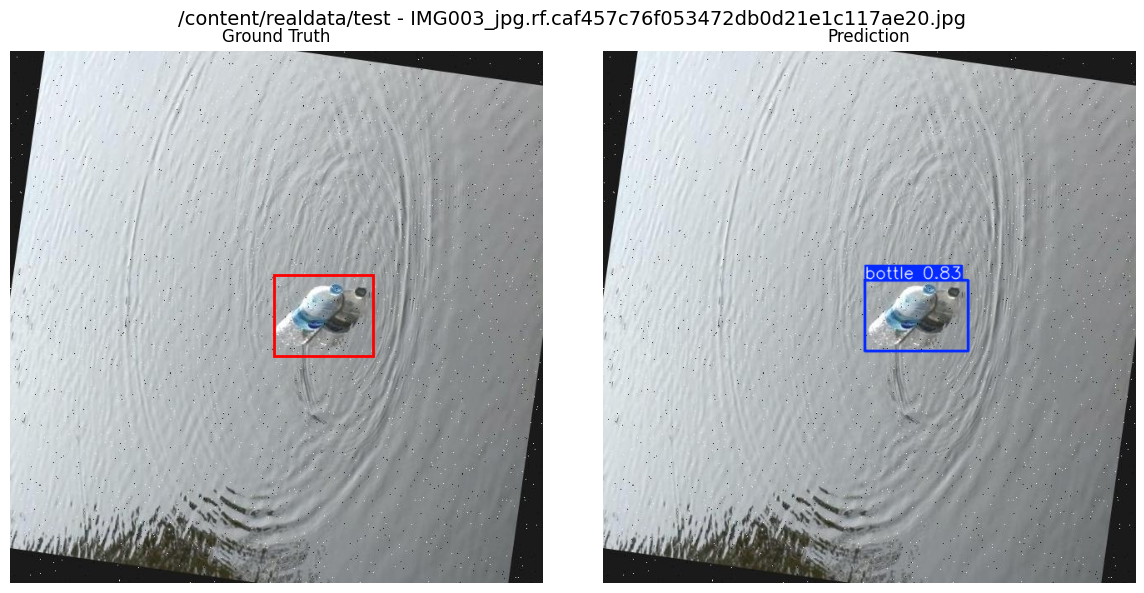

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/drive/MyDrive/Colab Notebooks/Bottle/Models/best_synthetic_yolov8s.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/realdata/test/images/IMG003_jpg.rf.caf457c76f053472db0d21e1c117ae20.jpg: 640x640 1 bottle, 19.7ms
Speed: 1.9ms preprocess, 19.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


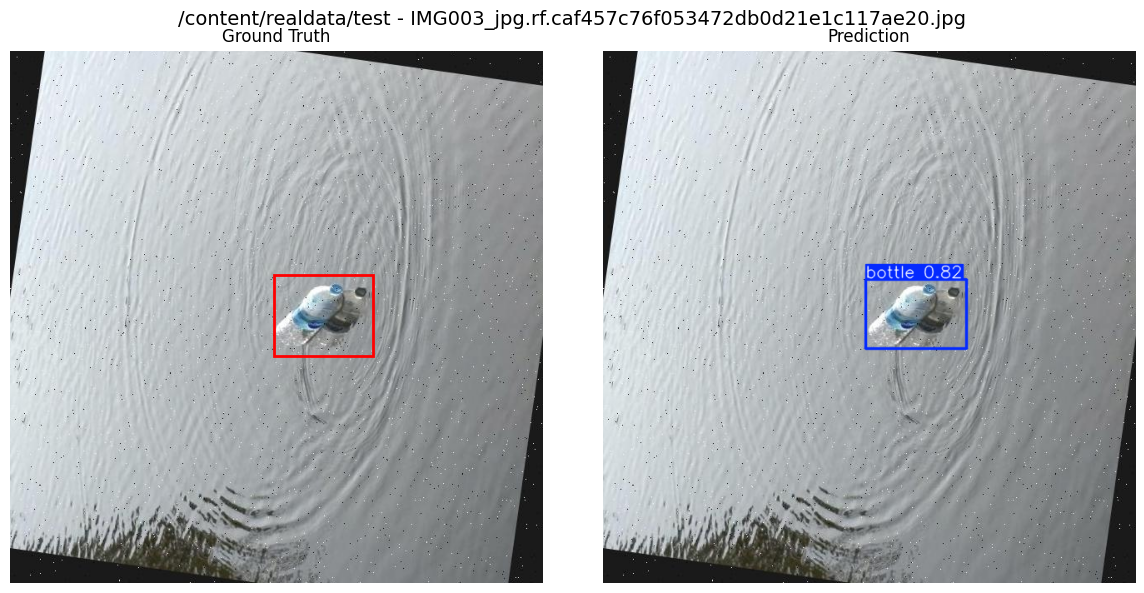

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/drive/MyDrive/Colab Notebooks/Bottle/Models/best_synthetic_yolov8m.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/realdata/test/images/IMG003_jpg.rf.caf457c76f053472db0d21e1c117ae20.jpg: 640x640 1 bottle, 52.4ms
Speed: 13.5ms preprocess, 52.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


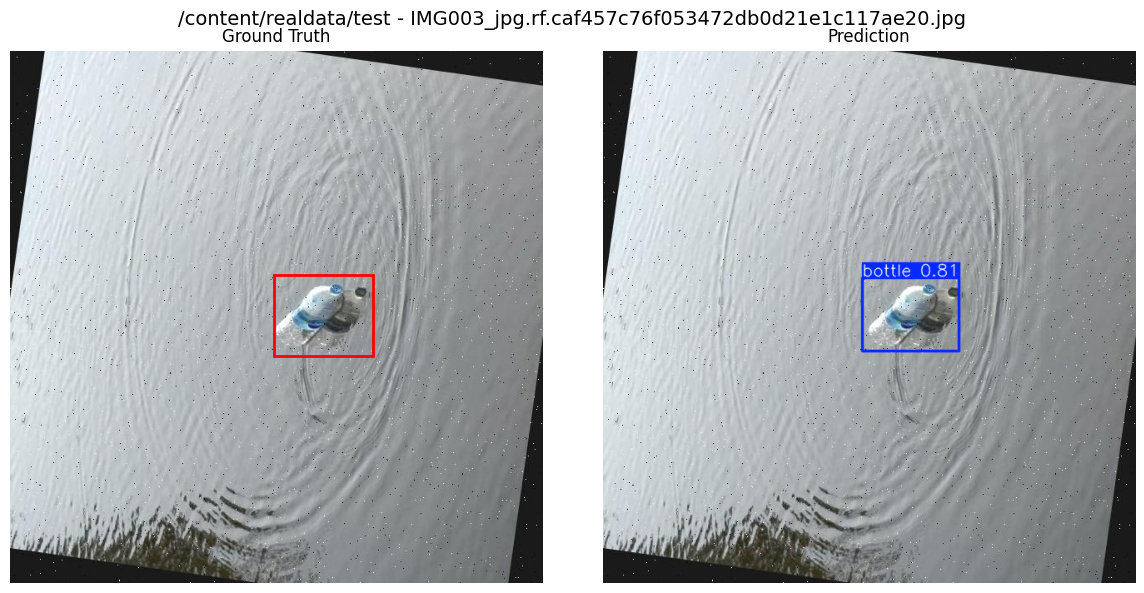

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/drive/MyDrive/Colab Notebooks/Bottle/Models/best_synthetic_yolov8l.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/realdata/test/images/IMG003_jpg.rf.caf457c76f053472db0d21e1c117ae20.jpg: 640x640 1 bottle, 65.8ms
Speed: 2.7ms preprocess, 65.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


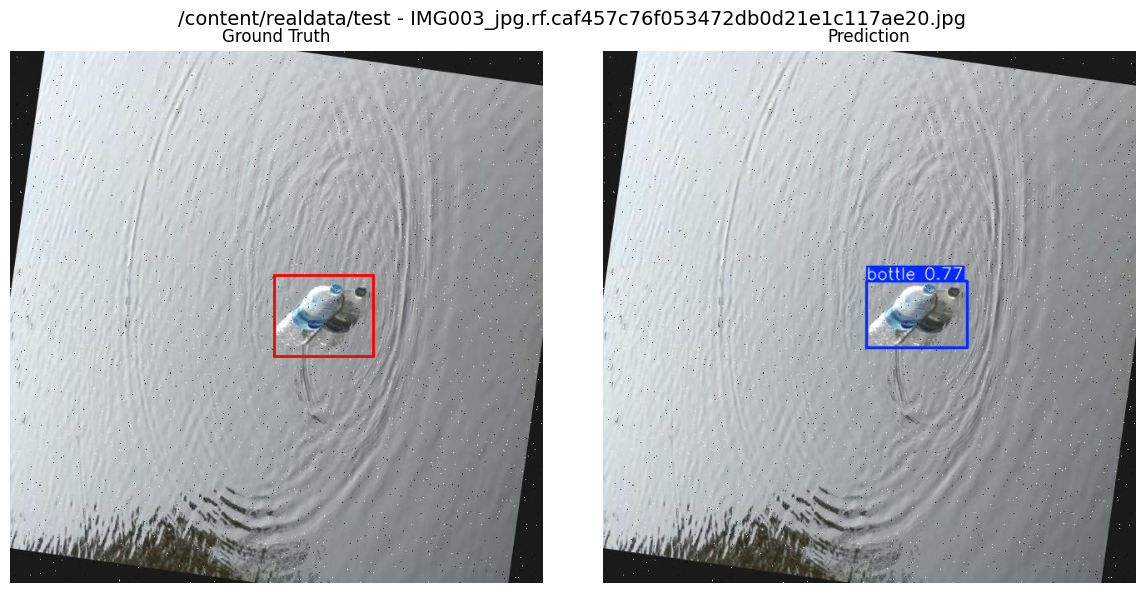

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/drive/MyDrive/Colab Notebooks/Bottle/Models/best_synthetic_yolov8x.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/realdata/test/images/IMG003_jpg.rf.caf457c76f053472db0d21e1c117ae20.jpg: 640x640 1 bottle, 100.5ms
Speed: 2.9ms preprocess, 100.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


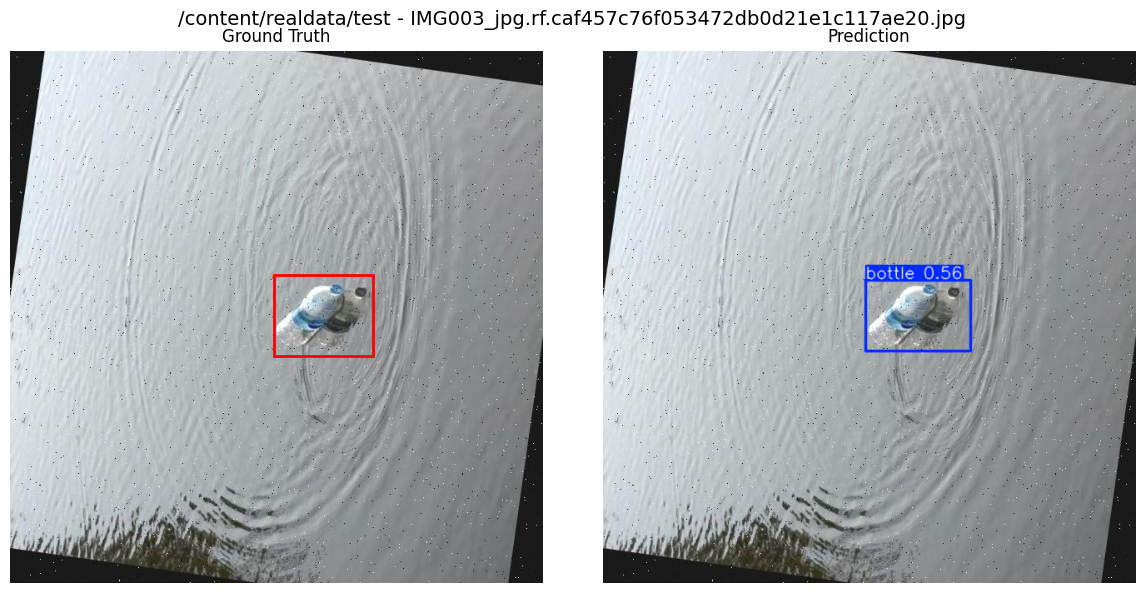

In [13]:
for version in versions:
    model_path = os.path.join(export_path, f"best_synthetic_{version}.onnx")
    model = YOLO(model_path)
    visualize_comparisons_test(real_folder, model)


# Optional: Close Colab runtime

In [14]:
# close runtime
from google.colab import runtime
runtime.unassign()
